# State machine implementation

In order to implement the desired turning upon mechanosensation of objects a state
machine was devised, along with a simple equation that describes the descending signals.
The concept is relatively simple, upon sensing an object on the flies right side sright it
should turn left and upon sensing an object on the left side slef t the fly should turn
right.


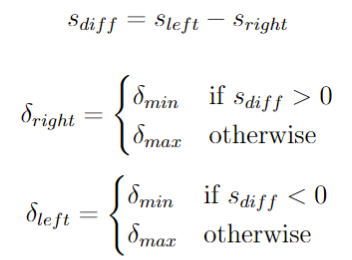

he main challenge in this implementation is that unlike olfaction and vision (for which
effective turning controllers have already been implemented), mechanosensation is a
sparse input, meaning that the bias for turning can not be continually computed based
on sensory input. This means that in addition to the simple equations devised for the
descending signals, it is also necessary to implement a period of time during which this
turning should be enforced after the initial sensory feedback of hitting an object. This
is where the state machine becomes relevant.

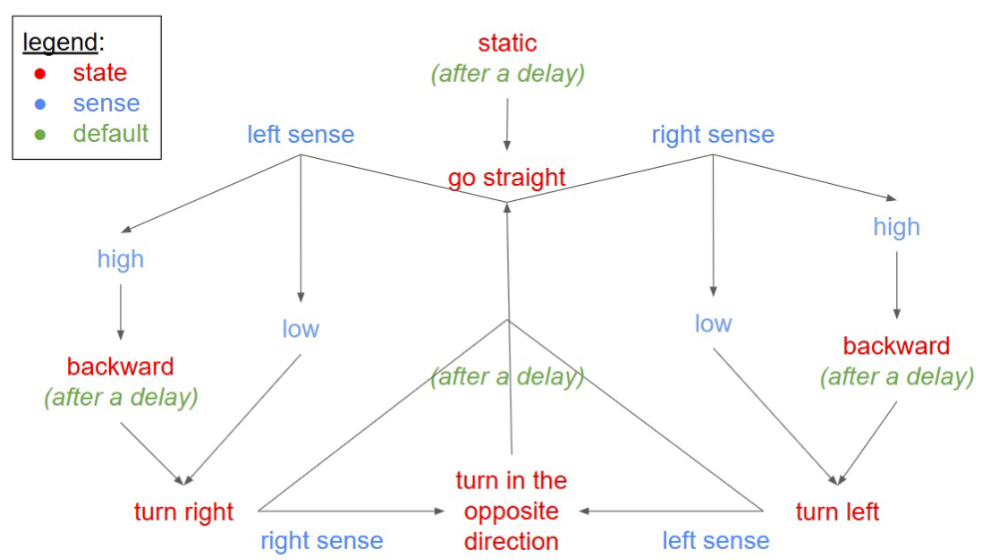

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange
from gymnasium.utils.env_checker import check_env
from IPython.display import Video
from enum import Enum, auto

from flygym.mujoco import Parameters
from flygym.mujoco.arena import FlatTerrain
from flygym.mujoco.examples.obstacle_arena import ObstacleOdorArena
from flygym.mujoco.examples.turning_controller import HybridTurningNMF

from scipy.signal import find_peaks
import pickle
from scipy.interpolate import interp1d
import flygym.mujoco

## Implementing environment

In [2]:
# We start by creating a arena with the flat terrain and some obstacles
flat_terrain_arena = FlatTerrain(friction=(1.75,0.005, 0.0001))

arena = ObstacleOdorArena(
    terrain=flat_terrain_arena,
    obstacle_positions=np.array([(7.5, 0), (13, 2.5), (12,7.5), (3.5,5), (17.5, 7.5), (7.5, 12.5)]),
    obstacle_colors=[(0.14, 0.14, 0.2, 1),(0.14, 0.14, 0.2, 1), (0.14, 0.14, 0.2, 1), (0.14, 0.14, 0.2, 1), (0.14, 0.14, 0.2, 1), (0.14, 0.14, 0.2, 1)],
    marker_size=0.5,
    # obstacle_colors=[(0.14, 0.14, 0.2, 1), (0.2, 0.8, 0.2, 1), (0.2, 0.2, 0.8, 1)],
    user_camera_settings=((13, -18, 9), (np.deg2rad(65), 0, 0), 45),
)

contact_sensor_placements = [
    f"{leg}{segment}"
    for leg in ["LF", "LM", "LH", "RF", "RM", "RH"]
    for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]

run_time = 4
sim_params = flygym.mujoco.Parameters(
    timestep=1e-4, 
    render_mode="saved", 
    render_playspeed=0.1, 
    draw_contacts=False,
    render_camera="user_cam"
    # render_camera="Animat/camera_top"
)

nmf = HybridTurningNMF(
    sim_params=sim_params,
    init_pose="stretch",
    ############## 0.5 default of the Neuromechfly (0.2 for the TurningController)
    spawn_pos=(10, -5, 0.5),
    spawn_orientation=(0, 0, np.pi / 2 + np.deg2rad(80)),
    ###############
    contact_sensor_placements=contact_sensor_placements,
    arena=arena
)

## Implement the backward walking

In [3]:
actuated_joints = flygym.mujoco.preprogrammed.all_leg_dofs

data_path = flygym.common.get_data_path("flygym", "data")
with open(data_path / "behavior" / "210902_pr_fly1.pkl", "rb") as f:
    data = pickle.load(f)

target_num_steps = int(run_time / sim_params.timestep)
data_block = np.zeros((len(actuated_joints), target_num_steps))
input_t = np.arange(len(data["joint_LFCoxa"])) * data["meta"]["timestep"]
output_t = np.arange(target_num_steps) * sim_params.timestep
for i, dof in enumerate(actuated_joints):
    data_block[i, :] = np.interp(output_t, input_t, data[dof])

# get the joint angle of the right hind leg tibia
rh_tibia_angle = data_block[actuated_joints.index("joint_RHTibia")]

# ===============================================================================================
# TODO: detect peaks in the tibia angle of the right hind leg using scipy.signal.find_peaks
# see https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html for usage
peak_frame_indices = find_peaks(rh_tibia_angle)[0]
# ===============================================================================================

cycle_n_frames = round(np.diff(peak_frame_indices).mean())

data_block_cycle = np.zeros((len(actuated_joints), cycle_n_frames))

for a, b in np.lib.stride_tricks.sliding_window_view(peak_frame_indices, 2):
    old_indices = np.arange(b - a)
    new_indices = np.linspace(0, old_indices.max(), cycle_n_frames)
    data_block_cycle += interp1d(old_indices, data_block[:, a:b])(new_indices)

data_block_cycle /= len(peak_frame_indices) - 1

data_block_backwards = data_block_cycle.copy()
# data_block_backwards = data_block_backwards[:, ::-1]  # reverse the order of the frames

for i, (dof, angles) in enumerate(zip(actuated_joints, data_block_cycle)):
    # reassign the joint angles
    # (LF -> RH, RF -> LH, LM -> RM, RM -> LM, LH -> RF, RH -> LF)
    orig_dof = dof.translate(str.maketrans("LRFH", "RLHF"))[:8] + dof[8:]
    orig_angles = data_block_cycle[actuated_joints.index(orig_dof)]
    # rescale to match the range of the joint angles of that leg
    data_block_backwards[i] = (
        orig_angles - orig_angles.min()
    ) / orig_angles.ptp() * angles.ptp() + angles.min()


## Implementing the state machine

In this state machine there are six discrete states. ”Static”, during which the fly
does not move. This is the initial state of the fly. After a set period of time a transition
to the next state, ”go straight”, is triggered. The fly will continue to go straight until
it encounters some mechanosensation consistent with running into an object. If this
sensation is just a small grazing of the object it will trigger a transition into the ”turn”
state, during which the descending signal is set based on equations 4 and 5, and a
turning timer will be set. This change in descending signal will persist until the turning
timer is up after which it will go back to the ”go straight” state, or until the fly senses
an object on the opposite side of where it initially sensed the object. In this scenario
the fly should instead start turning in the opposite direction.


However if the fly is going straight and it senses a high force consistent with run-
ning into an object straight on, this will trigger a transition in to the ”backward” state
in which the fly moves a slight amount backward. This is necessary since in order to
turn, the fly moves slightly forward while turning. Thus if it hits an object head on it
needs to create space between itself and the object in order to perform a turn. After
the backward movement it transitions into the ”turn state” which is the same as the
one for the grazing scenario.


In [ ]:
from enum import Enum, auto

# Random State Seed for Reproducibility (On the same machine)
seed = 1

# Definition of the states of the FSM
class State(Enum):
    GO_STRAIGHT = 1
    TURN_LEFT = 2
    TURN_RIGHT = 3
    REVERSE = 4

# Example of setting a current state
current_state = State.GO_STRAIGHT
next_state = State.GO_STRAIGHT

# Low Force Threshold: Turn
low_force_thresh = 2
# High Force Threshold: Need to Reverse
high_force_thresh = 5


enforce_time = 0
turn_delay = 200
reverse_delay = 1000

obs_hist = []
obs, _ = nmf.reset(seed)
bias = np.array([0,0])

for i in trange(int(run_time / nmf.sim_params.timestep)):
    curr_time = i
    # Front legs
    left_sense = np.array(obs["contact_forces"][:5, 0:2])
    right_sense = np.array(obs["contact_forces"][18:23, 0:2])
    left_sense_sum = np.abs(left_sense).sum()
    right_sense_sum = np.abs(right_sense).sum()
    
    # Middle legs
    left_sense_middle = np.array(obs["contact_forces"][6:11, 0:2])
    right_sense_middle = np.array(obs["contact_forces"][24:29, 0:2])
    left_sense_middle_sum = np.abs(left_sense_middle).sum()
    right_sense_middle_sum = np.abs(right_sense_middle).sum()

    orig = False

# Decision Making Process

    # (Default) State: Going Straight
    if current_state == State.GO_STRAIGHT:
        # Action: Go Straight
        control_signal = np.array([1, 1])
        # Using Unmodified Step Function (No Turning)
        orig = False

        #_______________________________________________________________________________________
        #_______________________________________________________________________________________
        # If High Force only Detected on Left Side
        if left_sense_sum > high_force_thresh or left_sense_middle_sum > high_force_thresh:
            print("High force detected on left side")
            current_state = State.REVERSE
            next_state = State.TURN_RIGHT
            enforce_time = curr_time + reverse_delay

        # If Low Force Detected on Left Side, NO REVERSE
        elif left_sense_sum > low_force_thresh or left_sense_middle_sum > low_force_thresh:
            print("Low force detected on left side")
            current_state = State.TURN_RIGHT
            enforce_time = curr_time + turn_delay

        # If High Force Detected only on Right Side
        elif right_sense_sum > high_force_thresh or right_sense_middle_sum > high_force_thresh:
            print("High force detected on right side")
            current_state = State.REVERSE
            next_state = State.TURN_LEFT
            enforce_time = curr_time + reverse_delay

        # If Low Force Detected on Right Side, NO REVERSE
        elif right_sense_sum > low_force_thresh or right_sense_middle_sum > low_force_thresh:
            print("Low force detected on right side")
            current_state = State.TURN_LEFT
            enforce_time = curr_time + turn_delay
        #_______________________________________________________________________________________
        #_______________________________________________________________________________________

    #_______________________________________________________________________________________
    #_______________________________________________________________________________________
    # State: Turning Right
    elif current_state == State.TURN_RIGHT:
        # activate the left leg only
        control_signal = np.array([1, 0])
        orig = False

        if left_sense_sum > high_force_thresh or left_sense_middle_sum > high_force_thresh:
            # resense the force on the left side, the fly is stuck --> reverse MORE
            current_state = State.REVERSE
            enforce_time = curr_time + reverse_delay

        elif left_sense_sum > low_force_thresh or left_sense_middle_sum > low_force_thresh:
            # resense the force on left side AGAIN --> turn MORE on right
            enforce_time = curr_time + turn_delay

        elif curr_time >= enforce_time:
            current_state = State.GO_STRAIGHT

    # State: Turning Left        
    elif current_state == State.TURN_LEFT:
        # activate the right leg only
        control_signal = np.array([0, 1])
        orig = False

        if right_sense_sum > high_force_thresh or right_sense_middle_sum > high_force_thresh:
            # resense the force on the right side, the fly is stuck --> reverse MORE
            current_state = State.REVERSE
            enforce_time = curr_time + reverse_delay

        elif right_sense_sum > low_force_thresh or right_sense_middle_sum > low_force_thresh:
            # resense the force on right side AGAIN --> turn MORE on left
            enforce_time = curr_time + turn_delay

        elif curr_time >= enforce_time:
            current_state = State.GO_STRAIGHT

    # State: Reversing       
    elif current_state == State.REVERSE:
        # print("Reversing")
        # control_signal = reverse_control_signal
        joint_pos = data_block_backwards[:, i % cycle_n_frames]
        control_signal = {"joints": joint_pos}
        orig = True
        # enforce_time = curr_time + reverse_delay
        
        if curr_time >= enforce_time:
            current_state = next_state

            # reset the enforce time for the turning
            enforce_time = curr_time + turn_delay

    if i > 1000:
        obs, reward, terminated, truncated, info = nmf.step(control_signal, orginal_action = orig)     
    else:
        obs, reward, terminated, truncated, info = nmf.step(np.array([0, 0]), orginal_action= False)
    
    obs_hist.append(obs)
    nmf.render()

nmf.save_video("./outputs/pillars.mp4")
Video("./outputs/pillars.mp4")